In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

#### Modelisation of $A_t^i=\sum_{n=1}^{N_t^i}U_n^i$

In [2]:
# N_t^i is a Possion process with parameter lambda_i

class combination_exponential():
    """
        Combination of two exponential random variables which models the strong and weak rainfalls, the distribution is given by:
        nu(u) = b*delta_1*exp(-delta_1*u)1_{u>0} + (1-b)*delta_2*exp(-delta_2*u)1_{u>0}
    """
    def __init__(self, b, delta_1, delta_2):
        assert b > 0 and b < 1
        assert delta_1 > 0
        assert delta_2 > 0
        self.b = b
        self.delta_1 = delta_1
        self.delta_2 = delta_2

    def pdf(self, u):
        """
            Probability density function of the combination of two exponential random variables
        """
        if u >= 0:
            return self.b*self.delta_1*np.exp(-self.delta_1*u) + (1-self.b)*self.delta_2*np.exp(-self.delta_2*u)
        else:
            return 0

    def cdf(self, u):
        """
            Cumulative distribution function of the combination of two exponential random variables
        """
        assert u >= 0
        return self.b*(1-np.exp(-self.delta_1*u)) + (1-self.b)*(1-np.exp(-self.delta_2*u))
    
    def rvs(self, size):
        """
            Random variates of the combination of two exponential random variables
        """
        X = np.random.rand(size)
        return np.random.exponential(1/self.delta_1, size=size) * self.b + np.random.exponential(1/self.delta_2, size=size) * (1-self.b)
        # return np.random.exponential(1/self.delta_1, size=size) * (X < self.b) + np.random.exponential(1/self.delta_2, size=size) * (X >= self.b)

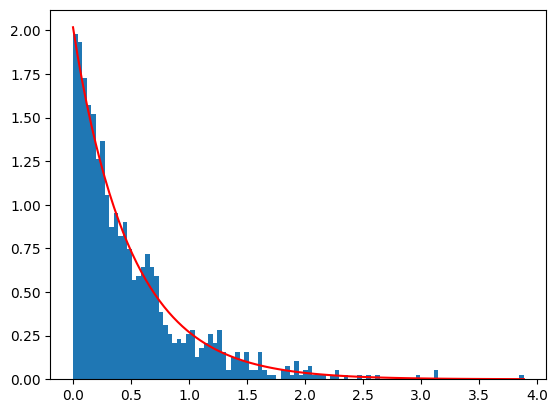

In [3]:
ce = combination_exponential(0.999, 2, 20)
X = ce.rvs(1000)

plt.hist(X, bins=100, density=True)
plt.plot(np.linspace(0, np.max(X), 100), [ce.pdf(x) for x in np.linspace(0, np.max(X), 100)], 'r')
plt.show()

In [107]:
from typing import List
class Rainfall():
    """
        Rainfall model
    """
    def __init__(self, lam, b, delta_1, delta_2, r, t=None, U_t=None):
        self.lam = lam
        self.b = b
        self.delta_1 = delta_1
        self.delta_2 = delta_2
        self.r = r
        self.ce = combination_exponential(b, delta_1, delta_2)
        # list which represents the Possion process N_t
        if t is None:
            self.t : List = []
        else:
            self.t = t
        # list which represents the quantities of rainfalls at the times t_i
        if U_t is None:
            self.U_t : List = []
        else:
            self.U_t = U_t
    def simulate_for_fixed_T(self, T):
        """
            Simulate the rainfalls on [0, T]
        """
        N_t = sps.poisson.rvs(self.lam*T)
        # no zero at the first
        self.t = np.sort(np.random.uniform(0, T, N_t))
        self.U_t = self.ce.rvs(N_t)

    def reset(self):
        """
            Reset the model
        """
        self.t = []
        self.U_t = []

    def copy(self):
        R = Rainfall(self.lam, self.b, self.delta_1, self.delta_2, self.r, self.t, self.U_t)
        return R
    
    def merge(self, t, U_t):
        """
            Merge two different rainfalls
        """
        merged_t = np.concatenate((self.t, t))
        merged_U_t = np.concatenate((self.U_t, U_t))
        sorted_indices = sorted(range(len(merged_t)), key=lambda k: merged_t[k])
        sorted_t = np.array(sorted(merged_t))
        sorted_U_t = np.array([merged_U_t[i] for i in sorted_indices])
        return Rainfall(self.lam, self.b, self.delta_1, self.delta_2, self.r, sorted_t, sorted_U_t)
    
    def get_volume(self, x0):
        """
            Get the volume of the barrage on [0, T]
            '''math
                X_t = x0 + A_t - int_0^t r*X_s ds
            '''
        """
        X = [x0]
        for i in range(1, len(self.t)):
            X.append(np.exp(-self.r*(self.t[i]-self.t[i-1]))*X[-1]+self.U_t[i])
        return X
    
    def get_volume_at_t(self, X, t):
        """
            Get the volume of the barrage at time t
        """
        if t > self.t[-1]:
            return np.exp(-self.r*(t-self.t[-1]))*X[-1]
        if t < self.t[0]:
            return np.exp(-self.r*t)*X[0]

        # get i such that t_i <= t < t_{i+1}
        i = 1
        while self.t[i] <= t and i < len(self.t)-1:
            i += 1
        return np.exp(-self.r*(t-self.t[i-1]))*X[i-1]



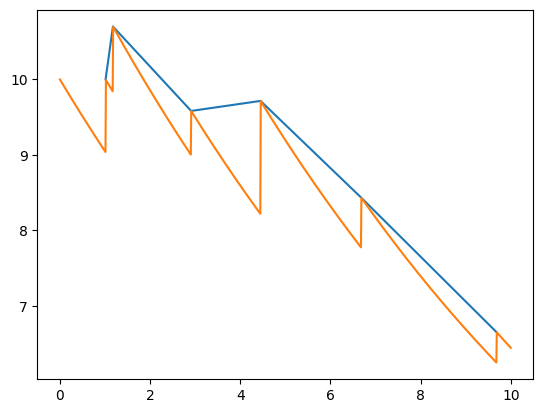

In [92]:
R = Rainfall(1, 0.999, 2, 20, 0.1)
R.simulate_for_fixed_T(10)
X = R.get_volume(10)
x = np.linspace(0, 10, 1000)
y = [R.get_volume_at_t(X, t) for t in x]
plt.plot(R.t, X)
plt.plot(x, y)
plt.show()

### Study of a single barrage

In [119]:
lambda_1 = 1
delta_1 = 0.07
delta_2 = 0.7
b = 0.9
alpha = 1e-6
T = 10
r_1 = 0.1

N = 1000
M = 20

class last_particle():
    """
        Last particle algorithm    
    """
    def __init__(self, N, M, x0, T, mode):
        """
            __T__ for Q1.(a) and __max__ for Q1.(b)
        """
        self.N = N
        self.M = M
        self.x0 = x0
        self.T = T
        self.mode = mode

    def get_new_rainfall(self, R, L, p=0.5):
        """
            Obtain a new rainfall > L almost independent from the original one
        """
        R_start = R.copy()
        for l in range(self.M):
            Unif = np.array(np.random.uniform(0, 1, len(R_start.t)))
            retained_indices = np.argwhere(Unif <= p)
            retained_indices = retained_indices.ravel()
            t_p = R_start.t[retained_indices]
            U_t_initial_p = R_start.U_t[retained_indices]
            R_other = Rainfall(R.lam*(1-p), R.b, R.delta_1, R.delta_2, R.r)
            R_other.simulate_for_fixed_T(self.T)
            
            # Mention that for those U_t preserved, it is necessary to choose a new one with P(U_t, ·), where P is nu-revertible, c.f. silde 3 page 28 
            # Use Metropolis-Hastings algorithm here, with q = standard gaussian, c.f. silde 2 page 22
            nu = combination_exponential(R.b, R.delta_1, R.delta_2)
            q_variation = np.array(np.random.randn(len(U_t_initial_p)))
            Unif = np.array(np.random.uniform(0, 1, len(U_t_initial_p)))
            U_t_p = q_variation + U_t_initial_p
            selected_indices = [Unif[i] <= np.minimum(1, nu.pdf(U_t_p[i])/nu.pdf(U_t_initial_p[i])) for i in range(len(U_t_initial_p))]
            U_t_p = U_t_initial_p + q_variation*selected_indices

            R_next = R_other.merge(t_p, U_t_p)
            R_next.lam = R.lam
            X_t_next = R_next.get_volume(self.x0)
            if self.mode == "__T__":
                if R_next.get_volume_at_t(X_t_next, T) > L:
                    R_start = R_next
            if self.mode == "__max__":
                if np.max(X_t_next) > L:
                    R_start = R_next
        return R_start

    def get_critical_level(self, lam, b, delta_1, delta_2, r, alpha):
        """
            Obtain the critical level of (1 - alpha)
        """
        A_t = []
        critical_X_t = []
        for l in range(self.N):
            R_initial = Rainfall(lam, b, delta_1, delta_2, r)
            R_initial.simulate_for_fixed_T(self.T)
            A_t.append(R_initial)
            X_t_initial = R_initial.get_volume(self.x0)
            if self.mode == "__T__":
                critical_X_t.append(R_initial.get_volume_at_t(X_t_initial, T))
            if self.mode == "__max__":
                critical_X_t.append(np.max(X_t_initial))
        L = np.min(critical_X_t)

        # c.f. silde 4 part 1 page 13
        stop_index = int(np.ceil(np.log(alpha) / np.log(1-1/self.N)))
        for l in range(stop_index):
            reached_indices = np.argwhere(critical_X_t == L)
            reached_indices = reached_indices.ravel()
            outer_indices = np.setdiff1d(np.arange(self.N), reached_indices)
            for i in reached_indices:
                j = np.random.choice(outer_indices)
                R_new = self.get_new_rainfall(A_t[j], L)
                A_t[i] = R_new
                X_t_new = R_new.get_volume(self.x0)
                if self.mode == "__T__":
                    critical_X_t[i] = R_new.get_volume_at_t(X_t_new, T)
                if self.mode == "__max__":
                    critical_X_t[i] = np.max(X_t_new)
            L = np.min(critical_X_t)
        return L

In [122]:
alg_max = last_particle(N, M, 100, 20, "__max__")
alg_T = last_particle(N, M, 100, 20, "__T__")
R = Rainfall(1, 0.9, 0.07, 0.7, 0.1)
R.simulate_for_fixed_T(20)
print(alg_max.get_critical_level(1, 0.9, 0.07, 0.7, 0.1, 0.0001))
print(alg_T.get_critical_level(1, 0.9, 0.07, 0.7, 0.1, 0.0001))

402.9224721497171
331.9999249405149
